## Embeddings with gensim

In [1]:
import gensim
from gensim import corpora

In [2]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [3]:
documents = ["Human machine interface for lab abc computer applications",              
             "A survey of user opinion of computer system response time",
             "The EPS user interface management system",
             "System and human system engineering testing of EPS",
             "Relation of user perceived response time to error measurement",
             "The generation of random binary unordered trees",
             "The intersection graph of paths in trees",
             "Graph minors IV Widths of trees and well quasi ordering",
             "Graph minors A survey"]

In [4]:
stoplist = set('un uno una in di gli e a il la dal'.split())
texts = [[word for word in document.lower().split() if word not in stoplist]
         for document in documents]

# remove words that appear only once
from collections import defaultdict
frequency = defaultdict(int)
for text in texts:
    for token in text:
        frequency[token] += 1

texts = [[token for token in text if frequency[token] > 1]
         for text in texts]

from pprint import pprint  # pretty-printer
pprint(texts)

[['human', 'interface', 'computer'],
 ['survey', 'of', 'user', 'of', 'computer', 'system', 'response', 'time'],
 ['the', 'eps', 'user', 'interface', 'system'],
 ['system', 'and', 'human', 'system', 'of', 'eps'],
 ['of', 'user', 'response', 'time'],
 ['the', 'of', 'trees'],
 ['the', 'graph', 'of', 'trees'],
 ['graph', 'minors', 'of', 'trees', 'and'],
 ['graph', 'minors', 'survey']]


In [5]:
dictionary = corpora.Dictionary(texts)

2018-05-21 00:47:28,407 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2018-05-21 00:47:28,408 : INFO : built Dictionary(15 unique tokens: ['computer', 'human', 'interface', 'of', 'response']...) from 9 documents (total 41 corpus positions)


In [6]:
print(dictionary)

Dictionary(15 unique tokens: ['computer', 'human', 'interface', 'of', 'response']...)


## GloVe italian vectors from http://hlt.isti.cnr.it/wordembeddings/

Warning: both glove and word2vec representations don't load with gensim, maybe because of version compatibility issues. 
glove works with numpy load

In [7]:
import numpy as np

In [8]:
glove_syn0 = np.load('../embeddings/glove/glove_WIKI.syn0.npy')

In [9]:
model = np.load('../embeddings/glove/glove_WIKI')

In [10]:
print(model.vocab['cane'])

Vocab(count:10071, index:2979)


It seems glove_WIKI to contain the indexes and counts, glove_WIKI.syn0.npy the vector representations

In [11]:
print(len(model.vocab))
print(glove_syn0.shape)

730613
(730613, 300)


In [12]:
def get_vec(word):
    idx = model.vocab[word].index
    return glove_syn0[idx]

In [13]:
def cosine_similarity(u, v):
    norm_u = np.linalg.norm(u)
    norm_v = np.linalg.norm(v)
    cosine_similarity = np.dot(u,v) / (norm_u * norm_v)
    return cosine_similarity

In [14]:
for key in model.vocab.keys():
    print(key, get_vec(key))
    if key == 'aliblu':
        break

aliblu [-0.09199844 -0.06161001  0.0513023  -0.02012069  0.07105082  0.00846289
 -0.00459384 -0.08879466 -0.0035946   0.03371745  0.04757003  0.00229248
 -0.02591361 -0.01174484  0.00898605  0.02664728 -0.09282714 -0.07773107
  0.09546513  0.02131889  0.03299978 -0.08644     0.0047928  -0.08496468
 -0.01767722  0.05779691 -0.01411637  0.06162422  0.0016503  -0.08599768
 -0.04406603 -0.03791782  0.00045477  0.00349956  0.05741498 -0.01138067
  0.07002672  0.09345689 -0.02946114  0.10645854 -0.10180698 -0.018839
 -0.02646875 -0.00252874  0.09949052  0.01786196 -0.01009898  0.07177738
 -0.07735892 -0.02459639  0.016209   -0.06548262  0.01803961  0.02612057
 -0.0319277  -0.00881463 -0.02501386  0.00121863  0.06306313  0.09990264
  0.00945059  0.04806831  0.04320179  0.03108657 -0.03380006  0.05053399
  0.10840018 -0.09168135  0.02464969 -0.0237748  -0.06466813  0.0155304
  0.08563173  0.05563056 -0.0565845  -0.01020113  0.04885883  0.0088697
  0.02562406 -0.02774422  0.08881687  0.04571721

In [15]:
u = get_vec('madre')
v = get_vec('padre')

In [16]:
cosine_similarity(u,v)

0.72584289

In [17]:
francia = get_vec('francia')
italia = get_vec('italia')
parigi = get_vec('parigi')
roma = get_vec('roma')

In [18]:
cosine_similarity(francia, italia)

0.63761288

In [19]:
cosine_similarity(parigi, roma)

0.63544673

In [20]:
cosine_similarity(francia - parigi, italia - roma)

0.4932012

In [21]:
def complete_analogy(word_a, word_b, word_c):
    """
    Performs the word analogy task as explained above: a is to b as c is to ____. 
    
    Arguments:
    word_a -- a word, string
    word_b -- a word, string
    word_c -- a word, string
    word_to_vec_map -- dictionary that maps words to their corresponding vectors. 
    
    Returns:
    best_word --  the word such that v_b - v_a is close to v_best_word - v_c, as measured by cosine similarity
    """
    
    # convert words to lower case
    word_a, word_b, word_c = word_a.lower(), word_b.lower(), word_c.lower()
    
    # Get the word embeddings v_a, v_b and v_c
    e_a, e_b, e_c = get_vec(word_a), get_vec(word_b), get_vec(word_c)
    
    words = model.vocab.keys()
    max_cosine_sim = -100              # Initialize max_cosine_sim to a large negative number
    best_word = None                   # Initialize best_word with None, it will help keep track of the word to output

    # loop over the whole word vector set
    for w in words:        
        # to avoid best_word being one of the input words, pass on them.
        if w in [word_a, word_b, word_c] :
            continue
            
        # Compute cosine similarity between the vector (e_b - e_a) and the vector ((w's vector representation) - e_c)  (≈1 line)
        cosine_sim = cosine_similarity(e_b - e_a, get_vec(w) - e_c)
        
        # If the cosine_sim is more than the max_cosine_sim seen so far,
            # then: set the new max_cosine_sim to the current cosine_sim and the best_word to the current word (≈3 lines)
        if cosine_sim > max_cosine_sim:
            max_cosine_sim = cosine_sim
            best_word = w
        
    return best_word

In [22]:
complete_analogy('parigi', 'francia', 'roma')

'italia'

In [23]:
# word2vec files, don't know howto manage
#syn0 = np.load('../embeddings/word2vec/wiki_iter=5_algorithm=skipgram_window=10_size=300_neg-samples=10.m.syn0.npy')
#syn1neg = np.load('../embeddings/word2vec/wiki_iter=5_algorithm=skipgram_window=10_size=300_neg-samples=10.m.syn1neg.npy')
#table = np.load('../embeddings/word2vec/wiki_iter=5_algorithm=skipgram_window=10_size=300_neg-samples=10.m.table.npy')
#print(syn0.shape)
#print(syn1neg.shape)
#print(table.shape)

## fastText and word2vec italian vectors from https://github.com/Kyubyong/wordvectors

In [24]:
from gensim.models.fasttext import FastText as ftext
from gensim.models.keyedvectors import KeyedVectors

In [25]:
wv_model = ftext.load_fasttext_format("../embeddings/fasttext/it/it")
fastvec = KeyedVectors.load_word2vec_format("../embeddings/fasttext/it/it.vec")

2018-05-21 00:47:38,480 : INFO : loading 50032 words for fastText model from ../embeddings/fasttext/it/it.bin
2018-05-21 00:47:42,086 : INFO : loading weights for 50032 words for fastText model from ../embeddings/fasttext/it/it.bin
2018-05-21 00:47:45,242 : INFO : loaded (50032, 300) weight matrix for fastText model from ../embeddings/fasttext/it/it.bin
2018-05-21 00:47:45,247 : INFO : loading projection weights from ../embeddings/fasttext/it/it.vec
2018-05-21 00:47:57,086 : INFO : loaded (50032, 300) matrix from ../embeddings/fasttext/it/it.vec


In [26]:
wv_model.wv.most_similar('regnante')

2018-05-21 00:47:57,090 : INFO : precomputing L2-norms of word weight vectors
2018-05-21 00:47:57,221 : INFO : precomputing L2-norms of ngram weight vectors


[('regnanti', 0.7557471990585327),
 ('sovrano', 0.7381712794303894),
 ('monarca', 0.6858254075050354),
 ('sovrani', 0.6832015514373779),
 ('regnare', 0.6770253777503967),
 ('casata', 0.6717057824134827),
 ('regnato', 0.6716135144233704),
 ('dinastia', 0.6574578285217285),
 ('reggente', 0.6570054292678833),
 ('casato', 0.64439857006073)]

In [27]:
wv_model.wv.similarity('cane', 'gatto')

0.57531984102463629

In [28]:
cosine_similarity(wv_model.wv.get_vector('cane'), wv_model.wv.get_vector('gatto'))

0.57531989

In [29]:
wv_model.wv.get_vector('cane').shape

(300,)

In [30]:
def print_similarities(text):
    tokens = text.split(' ')
    for token1 in tokens:
        for token2 in tokens:
            print(token1, token2, wv_model.wv.similarity(token1, token2))

In [31]:
print_similarities('cane coniglio mago')

cane cane 1.0
cane coniglio 0.545956969983
cane mago 0.31133601719
coniglio cane 0.545956969983
coniglio coniglio 1.0
coniglio mago 0.342039578075
mago cane 0.31133601719
mago coniglio 0.342039578075
mago mago 1.0


In [32]:
def complete_analogy_ft(word_a, word_b, word_c):
    word_a, word_b, word_c = word_a.lower(), word_b.lower(), word_c.lower()
    e_a, e_b, e_c = wv_model.wv.get_vector(word_a), wv_model.wv.get_vector(word_b), wv_model.wv.get_vector(word_c)
    
    words = wv_model.wv.vocab.keys()
    max_cosine_sim = -100              # Initialize max_cosine_sim to a large negative number
    best_word = None                   # Initialize best_word with None, it will help keep track of the word to output

    # loop over the whole word vector set
    for w in words:        
        # to avoid best_word being one of the input words, pass on them.
        if w.lower() in [word_a, word_b, word_c] :
            continue
            
        # Compute cosine similarity between the vector (e_b - e_a) and the vector ((w's vector representation) - e_c)  (≈1 line)
        cosine_sim = cosine_similarity(e_b - e_a, wv_model.wv.get_vector(w) - e_c)
        
        # If the cosine_sim is more than the max_cosine_sim seen so far,
            # then: set the new max_cosine_sim to the current cosine_sim and the best_word to the current word (≈3 lines)
        if cosine_sim > max_cosine_sim:
            max_cosine_sim = cosine_sim
            best_word = w
        
    return best_word

In [33]:
wv_model.wv.similarity('cane', 'gatto')

0.57531984102463629

In [34]:
complete_analogy('cattolico', 'prete', 'musulmano')

'sacerdote'

In [35]:
complete_analogy_ft('cattolico', 'prete', 'musulmano')

'schiavo'

In [36]:
wv_model.wv.most_similar(positive=['torino', 'piemonte'], negative=['milano'])

[('piemontese', 0.6713192462921143),
 ('piemontesi', 0.6520069241523743),
 ('cuneo', 0.588143527507782),
 ('liguria', 0.5686860680580139),
 ("d'aosta", 0.5568554401397705),
 ('torinese', 0.5420519113540649),
 ('vercelli', 0.5412924289703369),
 ('pinerolo', 0.5350003838539124),
 ('biellese', 0.5302784442901611),
 ('canavese', 0.5291153192520142)]

In [37]:
a = fastvec.get_vector('cane')
b = wv_model.wv.get_vector('cane')

In [38]:
from gensim.models.word2vec import Word2Vec as w2v 
word2vec_model = w2v.load('../embeddings/word2vec/it/it.bin')

2018-05-21 00:48:06,464 : INFO : loading Word2Vec object from ../embeddings/word2vec/it/it.bin
2018-05-21 00:48:06,568 : INFO : loading syn1neg from ../embeddings/word2vec/it/it.bin.syn1neg.npy with mmap=None
2018-05-21 00:48:06,606 : INFO : Model saved using code from earlier Gensim Version. Re-loading old model in a compatible way.
2018-05-21 00:48:06,607 : INFO : loading Word2Vec object from ../embeddings/word2vec/it/it.bin
2018-05-21 00:48:06,704 : INFO : loading syn1neg from ../embeddings/word2vec/it/it.bin.syn1neg.npy with mmap=None
2018-05-21 00:48:06,739 : INFO : loading syn0 from ../embeddings/word2vec/it/it.bin.syn0.npy with mmap=None
2018-05-21 00:48:06,785 : INFO : setting ignored attribute syn0norm to None
2018-05-21 00:48:06,785 : INFO : setting ignored attribute cum_table to None
2018-05-21 00:48:06,786 : INFO : loaded ../embeddings/word2vec/it/it.bin


#### gensim most_similar
positive = [x,y], negative = [z]

x + y – z = {result} => x - {result} = z - y
- donna + re - uomo = {regina}
- donna - {regina} = uomo - re

In [39]:
print(wv_model.wv.most_similar(positive=['donna', 're'], negative=['uomo'])[0])
print(word2vec_model.wv.most_similar(positive=['donna', 're'], negative=['uomo'])[0])

2018-05-21 00:48:06,934 : INFO : precomputing L2-norms of word weight vectors


('regina', 0.6258586645126343)
('regina', 0.6441910266876221)


In [40]:
print(wv_model.wv.most_similar(positive=['uomo', 'medico'], negative=['donna'])[0])
print(word2vec_model.wv.most_similar(positive=['donna', 're'], negative=['uomo'])[0])
print(wv_model.wv.most_similar(positive=['pace', 'violenza'], negative=['guerra'])[0])

('chirurgo', 0.5629442930221558)
('regina', 0.6441910266876221)
('nonviolenza', 0.516077995300293)


In [41]:
def analogy_by_wv(w1, w2, w3, wv):
    w = wv.most_similar(positive=[w3, w2], negative=[w1])[0]
    print(w1.upper(), "is to", w2.upper(), "as", w3.upper(), "is to", w[0].upper(), "-", round(w[1]*100), "%")

In [42]:
analogy_by_wv('uomo', 're', 'donna', wv_model.wv)
analogy_by_wv('cane', 'carne', 'gatto', wv_model.wv)
analogy_by_wv('campania', 'napoli', 'sicilia', wv_model.wv)
analogy_by_wv('fisica', 'scienza', 'astrologia', wv_model.wv)
analogy_by_wv('guerra', 'violenza', 'pace', wv_model.wv)
analogy_by_wv('roma', 'italia', 'londra', wv_model.wv)
analogy_by_wv('uomo', 'donna', 'maschio', wv_model.wv)
analogy_by_wv('toro', 'maschio', 'mucca', wv_model.wv)
analogy_by_wv('padre', 'dottore', 'madre', wv_model.wv)

UOMO is to RE as DONNA is to REGINA - 63 %
CANE is to CARNE as GATTO is to PEPERONI - 54 %
CAMPANIA is to NAPOLI as SICILIA is to PALERMO - 63 %
FISICA is to SCIENZA as ASTROLOGIA is to ESOTERISMO - 54 %
GUERRA is to VIOLENZA as PACE is to NONVIOLENZA - 52 %
ROMA is to ITALIA as LONDRA is to INGHILTERRA - 61 %
UOMO is to DONNA as MASCHIO is to FEMMINA - 73 %
TORO is to MASCHIO as MUCCA is to FEMMINA - 63 %
PADRE is to DOTTORE as MADRE is to DOTTORESSA - 62 %


### fasttext and w2v accuracy comparison on question words

In [43]:
acc_res = wv_model.wv.accuracy('../embeddings/question-words-ITA.txt')

2018-05-21 00:48:08,226 : INFO : capital-common-countries: 86.3% (295/342)
2018-05-21 00:48:10,712 : INFO : capital-world: 71.2% (534/750)
2018-05-21 00:48:11,008 : INFO : currency: 2.3% (2/86)
2018-05-21 00:48:13,309 : INFO : city-in-state: 23.5% (164/699)
2018-05-21 00:48:14,422 : INFO : regione capoluogo: 36.8% (126/342)
2018-05-21 00:48:15,336 : INFO : family: 75.4% (205/272)
2018-05-21 00:48:16,891 : INFO : gram1-adjective-to-adverb: 27.5% (127/462)
2018-05-21 00:48:17,103 : INFO : gram2-opposite: 35.7% (20/56)
2018-05-21 00:48:17,159 : INFO : gram3-comparative: 0.0% (0/12)
2018-05-21 00:48:17,403 : INFO : gram4-superlative (assoluto): 66.7% (38/57)
2018-05-21 00:48:18,906 : INFO : gram5-present-participle (gerundio): 88.7% (337/380)
2018-05-21 00:48:23,473 : INFO : gram6-nationality-adjective: 89.2% (1096/1229)
2018-05-21 00:48:25,683 : INFO : gram7-past-tense: 58.8% (353/600)
2018-05-21 00:48:29,546 : INFO : gram8-plural: 68.6% (724/1056)
2018-05-21 00:48:30,561 : INFO : gram9-p

In [44]:
acc_res_w2v = word2vec_model.wv.accuracy('../embeddings/question-words-ITA.txt')

2018-05-21 00:48:32,499 : INFO : capital-common-countries: 36.8% (126/342)
2018-05-21 00:48:35,169 : INFO : capital-world: 22.9% (172/750)
2018-05-21 00:48:35,491 : INFO : currency: 2.3% (2/86)
2018-05-21 00:48:37,946 : INFO : city-in-state: 6.3% (44/699)
2018-05-21 00:48:39,146 : INFO : regione capoluogo: 19.3% (66/342)
2018-05-21 00:48:40,094 : INFO : family: 44.5% (121/272)
2018-05-21 00:48:41,700 : INFO : gram1-adjective-to-adverb: 9.7% (45/462)
2018-05-21 00:48:41,904 : INFO : gram2-opposite: 23.2% (13/56)
2018-05-21 00:48:41,953 : INFO : gram3-comparative: 8.3% (1/12)
2018-05-21 00:48:42,162 : INFO : gram4-superlative (assoluto): 64.9% (37/57)
2018-05-21 00:48:43,517 : INFO : gram5-present-participle (gerundio): 85.3% (324/380)
2018-05-21 00:48:48,035 : INFO : gram6-nationality-adjective: 46.3% (569/1229)
2018-05-21 00:48:50,246 : INFO : gram7-past-tense: 43.3% (260/600)
2018-05-21 00:48:54,033 : INFO : gram8-plural: 20.5% (216/1056)
2018-05-21 00:48:54,979 : INFO : gram9-plural-

### Visualize with t-SNE

In [58]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

In [59]:
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
        if word == 'teatro':
            break
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

/Users/manuel/miniconda3/envs/wordgen-explore/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


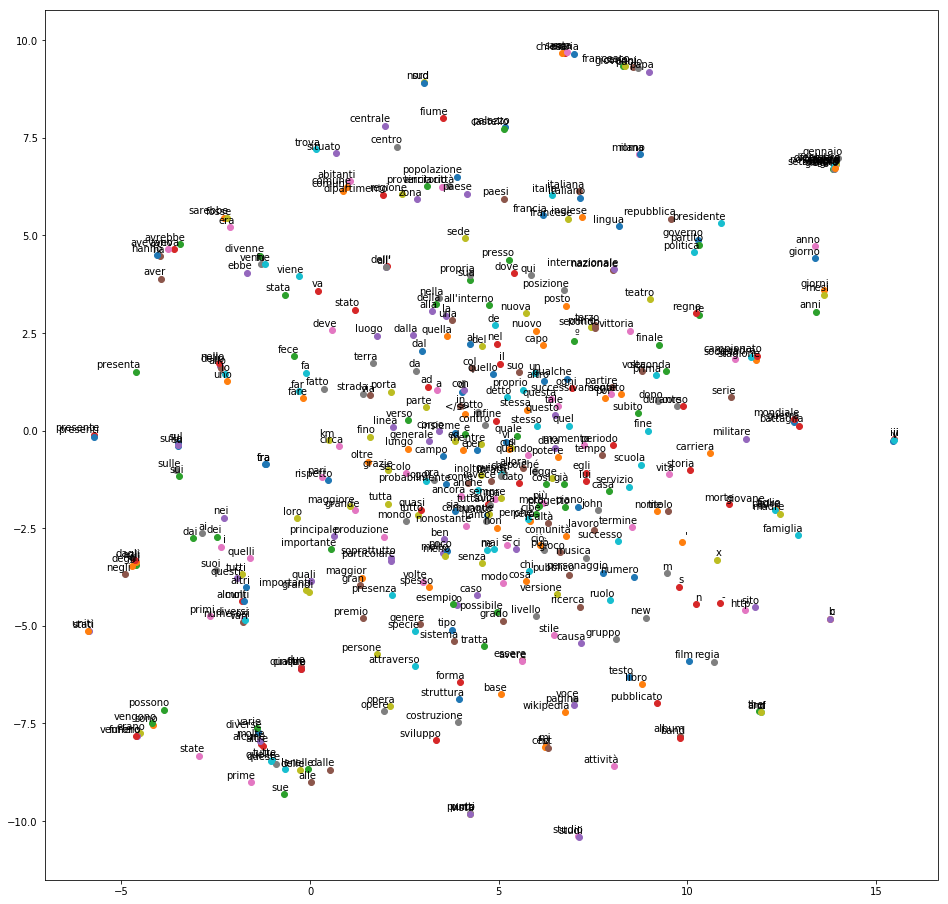

In [60]:
tsne_plot(wv_model)

## Embeddings with spacy

In [284]:
import spacy
nlp = spacy.load('it')
doc = nlp(u"Questa è una frase sciocca in un mondo che appartiene agli stolti.")
print([(w.text, w.pos_) for w in doc])

[('Questa', 'PRON'), ('è', 'VERB'), ('una', 'DET'), ('frase', 'NOUN'), ('sciocca', 'ADJ'), ('in', 'ADP'), ('un', 'DET'), ('mondo', 'NOUN'), ('che', 'PRON'), ('appartiene', 'VERB'), ('agli', 'DET'), ('stolti', 'NOUN'), ('.', 'PUNCT')]


In [287]:
tokens = nlp(u'cane gatto banana')

for token1 in tokens:
    for token2 in tokens:
        print(token1.text, token2.text, token1.similarity(token2))

cane cane 1.0
cane gatto 0.498379
cane banana 0.189059
gatto cane 0.498379
gatto gatto 1.0
gatto banana 0.17797
banana cane 0.189059
banana gatto 0.17797
banana banana 1.0


In [286]:
from spacy import displacy

In [9]:
displacy.serve(doc, style='dep',port=5050)


    Serving on port 5050...
    Using the 'dep' visualizer



127.0.0.1 - - [18/May/2018 23:33:46] "GET / HTTP/1.1" 200 9107
127.0.0.1 - - [18/May/2018 23:33:46] "GET /favicon.ico HTTP/1.1" 200 9107



    Shutting down server on port 5050.

